# Toroidal CWS

A notebook to run a shape + current optimization for a given plasma configuration

- Define the cost
- Set up the coil factory
- Set up the optimizer
- Run the optimization

In [1]:
%gui qt

from mayavi import mlab


from stellacode.costs import EMCost
from stellacode.surface import IntegrationParams
from stellacode.costs import (
    AggregateCost,
    DistanceCost,
    PoloidalCurrentCost,
    NegTorCurvatureCost,
    CurrentCtrCost,
)
from stellacode.costs.utils import Constraint

from stellacode.surface import WrappedCoil, FourierSurfaceFactory
from stellacode.optimizer import Optimizer

from stellacode.tools.plots import plot_CWS_LCFS, plot_cross_sections


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from stellacode.definitions import w7x_plasma
plasma_config = w7x_plasma

In [3]:


n_harmonics_tor = 16
n_harmonics_u = 4
n_harmonics_v = 4
factor = 4
rotate_diff_current = 3  # num_cyl

lamb = 1e-27
train_currents = True

maxiter = 2
optim_method = "L-BFGS-B"


In [4]:
integration_par = IntegrationParams(num_points_u=n_harmonics_u * factor, num_points_v=n_harmonics_v * factor)
Sp = FourierSurfaceFactory.from_file(plasma_config.path_plasma, integration_par=integration_par)

In [5]:
costs=[]

In [6]:
em_cost = EMCost.from_plasma_config(
    plasma_config=plasma_config,
    integration_par=integration_par,
    train_currents=train_currents,
    lamb=lamb,
)
costs.append(em_cost)

In [7]:
dist_lim = 0 # Sp().get_minor_radius()
distance = DistanceCost(
    Sp=em_cost.Sp,
    constraint=Constraint(limit=dist_lim, distance=1e-5,
                          minimum=True, method="quadratic"),
)
costs.append(distance)

In [8]:
# constraint preventing negative toroidal curvature
neg_curv = NegTorCurvatureCost(constraint=Constraint(limit=-0.05, distance=0.1, minimum=True, method="quadratic"))
costs.append(neg_curv)

Sum of all these costs

In [9]:
agg_cost = AggregateCost(costs=costs)

Definition of the coil factory

In [10]:
coil_factory = WrappedCoil.from_plasma(
    surf_plasma=em_cost.Sp,
    surf_type="toroidal",
    sin_basis=True,
    cos_basis=False,
    n_harmonics=n_harmonics_tor, # Number of harmonics in the current fourier expansion
    factor=factor, # The number of points on the grid is n_harmonics * factor
)

Definition of the optimizer

In [11]:
opt = Optimizer.from_cost(
    agg_cost,
    coil_factory,
    method=optim_method,
    kwargs=dict(
        options={"disp": True, "maxiter": maxiter},
    ),
    save_res=True,
    output_folder_name="../outputs/"
)

Initial values of the parameters before optimization

In [12]:
opt.init_param

{'0.major_radius': 5.5,
 '0.minor_radius': 0.9861277937889099,
 '0.fourier_coeffs': Array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 '1.0.phi_mn': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Run the optimization

In [13]:
cost, metrics, results, optimized_params = opt.optimize()
print(metrics)

max_deltaB_normal: 2.102590322494507, deltaB_B_rmse: 891.635986328125, deltaB_B_max: 451.041748046875, cost_B: 47.03384017944336, em_cost: 47.03384017944336, max_j: 2744255.75, min_distance: 0.05578085035085678, mean_min_distance: 5.078736782073975, max_distance: 12.662237167358398, mean_max_distance: 9.342249870300293, cost_distance: 0.0, min_v_curvature: 0.7708757519721985, cost_neg_pol_curv: 0.0, total_cost: 47.03384017944336, 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          554     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70338D+01    |proj g|=  5.72679D+03
max_deltaB_normal: 1994144.875, deltaB_B_rmse: 362.6852111816406, deltaB_B_max: 168.36981201171875, cost_B: 11532560.0, em_cost: 11532560.0, max_j: 5042037760.0, min_distance: 0.05601469799876213, mean_min_distance: 5.078734397888184, max_distance: 12.66227912902832, mean_max_distance: 9.342217445373535, cost_distance: 0.0, min_v_curvature: 0.771375834941864, cost_neg_pol_curv: 0.0, total_cost: 11532560.0, 
max_deltaB_normal: 2.0221798419952393, deltaB_B_rmse: 238.54925537109375, deltaB_B_max: 134.55738830566406, cost_B: 42.12785339355469, em_cost: 42.12785339355469, max_j: 4323439.0, min_distance: 0.055781289935112, mean_min_distance: 5.078736782073975, max_distance: 12.662237167358398, mean_max_distance: 9.342249870300293, cost_distance: 0.0, min_v_curvature:


At iterate    2    f=  3.75014D+01    |proj g|=  4.04164D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  554      2      4      1     0     0   4.042D+03   3.750D+01
  F =   37.501438140869141     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
{'max_deltaB_normal': Array(1.9413112, dtype=float32), 'deltaB_B_rmse': Array(227.87619, dtype=float32), 'deltaB_B_max': Array(92.0582, dtype=float32), 'cost_B': Array(37.501442, dtype=float32), 'em_cost': Array(37.501442, dtype=float32), 'max_j': Array(4947771.5, dtype=float32), 'min_distance': Array(0.0557831, dtype=float32), 'mean_min_distance': Array(5.07

We can now plot the results

/!\ the parameters of the coil factory were changed in place during the optimization

We can print the optimized parameters:

In [14]:
coil_factory.get_trainable_params()

{'0.major_radius': array(5.49999968),
 '0.minor_radius': array(0.98612862),
 '0.fourier_coeffs': array([[ 7.22832468e-11,  6.31077581e-13],
        [-8.98563647e-07, -3.04588465e-12],
        [ 2.14909979e-07,  1.16883007e-12],
        [ 5.52284743e-07,  2.31314002e-12]]),
 '1.0.phi_mn': array([-2.03697976e-05, -2.39704370e-05,  5.46097451e-07,  1.36457632e-06,
         8.44485274e-07,  2.19855549e-06,  3.78193171e-06, -2.68574851e-06,
        -8.05441050e-06, -3.87434955e-06,  1.83715157e-07,  6.07871438e-06,
         1.00866072e-05,  3.95684756e-05,  1.22461001e-05, -7.21519615e-05,
        -1.53913753e-05, -7.68562575e-05, -1.16768113e-05, -3.77723197e-05,
        -4.81803821e-08, -1.99523643e-06,  4.36701747e-07,  2.35316691e-06,
         5.62557403e-06,  2.92526452e-06, -1.27565785e-07, -1.89441505e-07,
        -5.28241418e-07,  3.13327630e-06,  2.00544521e-06,  1.87056643e-04,
         2.89178318e-04, -4.22893797e-04, -1.06463994e-04, -1.70505765e-05,
         1.50242562e-06,  7.

In [15]:
coil_surface = coil_factory().get_coil(results.phi_mn_wnet_cur)

coil_surface.plot(
    vector_field=coil_surface.j_3d,
    reduce_res=1,
    quiver_kwargs=dict(
        line_width=2,
        scale_factor=0.25,
    )
)

<PolarAxes: >

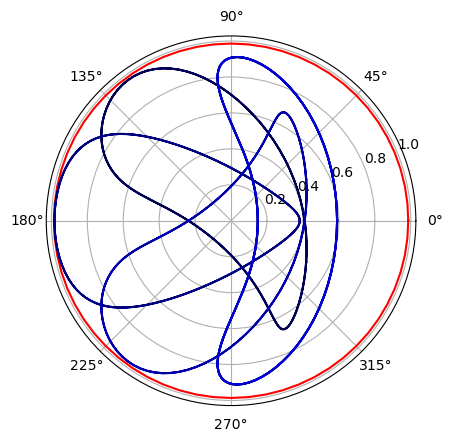

In [16]:
plot_cross_sections(coil_factory, Sp)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'CWS and LCFS'}, xlabel='X', ylabel='Y'>)

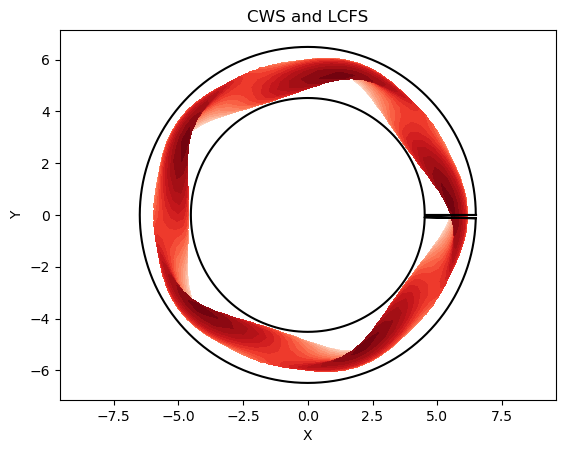

In [17]:
plot_CWS_LCFS(coil_surface, em_cost.Sp, n_cyl=0)